In [0]:
# required library
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [0]:
# uplaod local file on colab
from google.colab import files
uploaded = files.upload()

Saving Text_Similarity_Dataset.csv to Text_Similarity_Dataset.csv


In [0]:
# inport path of file and pass the data set
import io
df = pd.read_csv(io.BytesIO(uploaded['Text_Similarity_Dataset.csv']))

In [0]:
df = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df))

In [0]:
# heading of given dataset
df.head()

,Unique_ID,text1,text2
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...


In [0]:
## drpop unique id if required it's only for exxperiment purpose
# df.drop(['Unique_ID'],axis=1,inplace = True)

In [0]:
# check shape of dataset
df.shape

(4023, 3)

# problem :- Find most similar sentence between text1 and text2

# Method 1

In [0]:
## install fuzzywuzzy library
pip install fuzzywuzzy

# What is fuzzywuzzy
## FuzzyWuzzy is a library of Python which is used for string matching. Fuzzy string matching is the process of finding strings that match a given pattern. Basically it uses Levenshtein Distance to calculate the differences between sequences.
##FuzzyWuzzy has been developed and open-sourced by SeatGeek, a service to find sport and concert tickets. Their original use case, as discussed in their blog.
##### definition copied from -https://www.geeksforgeeks.org/fuzzywuzzy-python-library/

In [0]:
# import fuzzywuzzy library
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [0]:
## check in any null value in given dataset 
df.isnull().sum()

Unique_ID    0
text1        0
text2        0
dtype: int64

In [0]:
## define a function and pass a argument
def get_ratio(row):
  # assign value
    name = row['text1']
    name1 = row['text2']
    # return value through pre defined keyword(fuzzywuzzy)
    return fuzz.token_set_ratio(name, name1)
## set a percentage similarity threshold on 70 , you can check it also on other value
ratio = (df[df.apply(get_ratio, axis=1)>0 ].head())
print(ratio,fuzz.token_set_ratio)
## now what i want print these with their similaraty score

   index  ...                                              text2
0      0  ...  newcastle 2-1 bolton kieron dyer smashed home ...
1      1  ...  nasdaq planning $100m share sale the owner of ...
2      2  ...  ruddock backs yapp s credentials wales coach m...
3      3  ...  mci shares climb on takeover bid shares in us ...
4      4  ...  media gadgets get moving pocket-sized devices ...

[5 rows x 4 columns] <function token_set_ratio at 0x7f45c3304b70>


In [0]:
ratio

,index,Unique_ID,text1,text2
0,0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...
1,1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...
2,2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...
3,3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...
4,4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...


In [0]:
def get_ratio(name,name1):
    #name = row['text1']
    #name1 = row['text2']
    ratio=fuzz.token_set_ratio(name, name1)
    return(ratio)

## this time set a percentage similarity threshold on 90 , you can check it also on other value
#df.apply(lambda row : get_ratio(row), axis=1)>=0
# take a loop to print similarity score between text
for i in range (0,df.shape[0]):
  df.loc[i,'percentage_simlarity']=get_ratio(df.loc[i,'text1'],df.loc[i,'text2'])/100

In [0]:
df.head()
# head of dataframe with similarity score

,Unique_ID,text1,text2,percentage_simlarity
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...,0.27
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...,0.34
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...,0.27
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...,0.36
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...,0.41


In [0]:
fuzz.token_set_ratio(df.loc[3403,'text1'], df.loc[3403,'text2'])/100

1.0

In [0]:
len(df)

4023

In [0]:
# print those senteces whose similarity vlue is more than 60
df[df.apply(lambda row: fuzz.token_set_ratio(row['text1'], row['text2']), axis=1) > 60]

,index,Unique_ID,text1,text2
238,238,238,terror powers expose tyranny the lord chance...,blair labour s longest-serving pm tony blair h...
1118,1118,1118,tomlinson stays focused on europe long jumper ...,holmes back on form in birmingham double olymp...
1132,1132,1132,lib dems predict best ever poll the lib dems...,lib dems highlight problem debt people vulnera...
1397,1397,1397,a-listers flock to gervais sitcom hollywood ac...,roundabout continues nostalgia trip the new bi...
2284,2284,2284,dvd copy protection strengthened dvds will be ...,dvd copy protection strengthened dvds will be ...
2413,2413,2413,bush to get tough on deficit us president ge...,terror powers expose tyranny the lord chance...
2546,2546,2546,ireland 19-13 england ireland consigned englan...,yachvili savours france comeback france scrum-...
3403,3403,3403,holmes starts 2005 with gb events kelly holmes...,holmes starts 2005 with gb events kelly holmes...


In [0]:
  >>> import nltk
  >>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Method 2

## preprocessing

# TFIDFVECTORIZER

In [0]:
len(df)

4023

In [0]:
df.head()

,Unique_ID,text1,text2
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...


In [0]:

len(set(df))

3

In [0]:
def review_to_wordlist(review, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    review_text = " ".join(words)

    # Clean the text
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    words = review_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    # Return a list of words
    return(review_text)

In [0]:
def process_sentences(question_list, questions, question_list_name):
# function to transform questions and display progress
    for question in questions:
        question_list.append(review_to_wordlist(question))
        # len(question_list = 4000/1000)
        if len(question_list) % 1000 == 0:
          # now take percentage
            progress = len(question_list)/len(df) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [0]:
# download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
sentence1 = []     
process_sentences(sentence1, df.text1, "sentences1")
print()
sentence2 = []     
process_sentences(sentence2, df.text2, "sentences2")

sentences1 is 24.9% complete.
sentences1 is 49.7% complete.
sentences1 is 74.6% complete.
sentences1 is 99.4% complete.

sentences2 is 24.9% complete.
sentences2 is 49.7% complete.
sentences2 is 74.6% complete.
sentences2 is 99.4% complete.


In [0]:
# take a look at the some processed question 
for i in range(5):
    print(questions1[i],'\n')
    print(questions2[i], '\n')
    print()
    print((questions1[i]))
    print((questions2[i]))

savvi searcher fail spot ad internet search engin user odd mix naiv sophist suggest report search habit report us pew research center reveal 87 searcher usual find look use search engin also show spot differ paid for result organ one report reveal 84 net user say regular use googl ask jeev msn yahoo onlin almost 50 question said would trust search engin much less knew inform paid result hidden accord figur gather pew research averag user spend 43 minut per month carri 34 separ search look 1 9 webpag hunt signific chunk net user 36 carri search least week 29 ask look everi week 44 question inform look critic inform simpli find search engin user also tend loyal found site feel trust tend stick it accord pew research 44 searcher use singl search engin 48 use two three small number 7 consult three site toni macklin spokesman ask jeev said result reflect research show peopl use differ search engin way site gather inform mean provid differ result queri despit like search site half question s

In [0]:
# Stores the indices of unusable questions
invalid_sentences = []
for i in range(len(sentence1)):
    # questions need to contain a vowel (which should be part of a full word) to be valid
    if not re.search('[aeiouyAEIOUY]', sentence1[i]) or not re.search('[aeiouyAEIOUY]', sentence2[i]):
    # Need to subtract 'len(invalid_questions)' to adjust for the changing index values as questions are removed.
        invalid_sentences.append(i-len(invalid_sentencess))
print(len(invalid_sentences))

0


In [0]:
# Use TfidfVectorizer() to transform the questions into vectors,
# then compute their cosine similarity.
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [0]:
Tfidf_scores = []
for i in range(len(sentence1)):
    score = cosine_sim(sentence1[i], sentence2[i])
    Tfidf_scores.append(score)
    if i % 1000 == 0:
        progress = i/len(sentence1) * 100
        print("Similarity Scores is {}% complete.".format(round(progress,1)))

Similarity Scores is 0.0% complete.
Similarity Scores is 24.9% complete.
Similarity Scores is 49.7% complete.
Similarity Scores is 74.6% complete.
Similarity Scores is 99.4% complete.


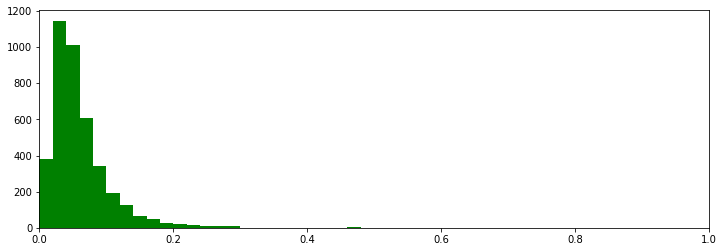

In [0]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(Tfidf_scores, bins = 50,color='green')
plt.xlim(0,1)
plt.show()

# Method 3 DOC2VEC

In [0]:
# Reset index to match the index values of questions1 and questions2
df = df.reset_index()

In [0]:
# Contains the processed questions for Doc2Vec
sentences_labeled = []

for i in range(len(sentence1)):
    # Question strings need to be separated into words
    # Each question needs a unique label
    sentences_labeled.append(LabeledSentence(sentence1[i].split(), df[df.index == i].Unique_ID))
    sentences_labeled.append(LabeledSentence(sentence2[i].split(), df[df.index == i].Unique_ID))
    if i % 1000 == 0:
        progress = i/len(sentence1) * 100
        print("{}% complete".format(round(progress, 2)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys


0.0% complete
24.86% complete
49.71% complete
74.57% complete
99.43% complete


In [0]:
# Split questions for computing similarity and determining the lengths of the questions.
sentence1_split = []
for sentence in sentence1:
    sentence1_split.append(sentence.split())
    
sentence2_split = []
for sentence in sentence2:
    sentence2_split.append(sentence.split())

In [0]:
# Determine the length of questions to select more optimal parameters.
lengths = []
for i in range(len(sentence1_split)):
    lengths.append(len(sentence1_split[i]))
    lengths.append(len(sentence2_split[i]))
lengths = pd.DataFrame(lengths, columns=["count"])

In [0]:
lengths['count'].describe()

count    8046.000000
mean      231.206438
std       133.771207
min        50.000000
25%       151.000000
50%       204.000000
75%       282.000000
max      2296.000000
Name: count, dtype: float64

In [0]:
lengths['count'].values

array([290, 395, 296, ..., 140, 217, 117])

In [0]:
# 99% of the questions  or fewer words.
np.percentile(lengths['count'], 99)

571.0

In [0]:
# Build the model
model = Doc2Vec(dm = 1, min_count=1, window=10, size=150, sample=1e-4, negative=10)
model.build_vocab(sentences_labeled)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [0]:
model.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('magan', 0.3290099799633026),
 ('isitt', 0.30083125829696655),
 ('cyberspac', 0.2792191505432129),
 ('while', 0.2787034213542938),
 ('victori', 0.2776039242744446),
 ('tent', 0.2752862274646759),
 ('scannel', 0.27276384830474854),
 ('conmen', 0.27185767889022827),
 ('jiulin', 0.2706533968448639),
 ('randal', 0.266573041677475)]

In [0]:
model.most_similar('peopl')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('unsophist', 0.34624841809272766),
 ('impoverish', 0.3030472695827484),
 ('incub', 0.2963082492351532),
 ('facey', 0.293937087059021),
 ('rob', 0.2906617224216461),
 ('liang', 0.27060115337371826),
 ('angel', 0.26653432846069336),
 ('mcguir', 0.2661038339138031),
 ('rous', 0.2660773694515228),
 ('knot', 0.2655090093612671)]

In [0]:
model.most_similar('book')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dismount', 0.30609554052352905),
 ('cannist', 0.2998250722885132),
 ('elaps', 0.28491801023483276),
 ('goldstein', 0.2807214856147766),
 ('moin', 0.2794002592563629),
 ('inc', 0.2682351768016815),
 ('truer', 0.2661641538143158),
 ('corr', 0.25854918360710144),
 ('inspector', 0.25733131170272827),
 ('leinster', 0.25725871324539185)]

In [0]:
model.most_similar('note')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('congest', 0.31521958112716675),
 ('377bn', 0.3075938820838928),
 ('headach', 0.2998121976852417),
 ('boers', 0.29192426800727844),
 ('regular', 0.2848879098892212),
 ('nishioka', 0.2775861322879791),
 ('unenforc', 0.27272382378578186),
 ('deccan', 0.2679932415485382),
 ('underwhelm', 0.26735490560531616),
 ('kickabl', 0.265718936920166)]

In [0]:
doc2vec_scores = []
for i in range(len(sentence1_split)):
    # n_similarity computes the cosine similarity in Doc2Vec
    score = model.n_similarity(sentence1_split[i],sentence2_split[i])
    doc2vec_scores.append(score)
    if i % 1000 == 0:
        progress = i/len(sentence1_split) * 100
        print("{}% complete.".format(round(progress,2)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.0% complete.
24.86% complete.
49.71% complete.
74.57% complete.
99.43% complete.


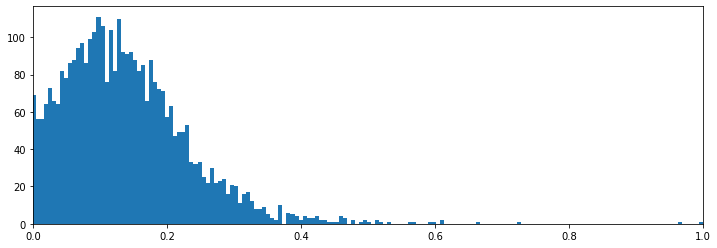

In [0]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(doc2vec_scores, bins = 200)
plt.xlim(0,1)
plt.show()

### interpretation

* It's interesting to see how Doc2Vec computes the pairs of questions to be more similar than TfidfVectorizer.